# DEA Coastlines annual snapshot <img align="right" src="https://github.com/GeoscienceAustralia/dea-notebooks/raw/develop/Supplementary_data/dea_logo.jpg">

Generate annual snapshot infographic to accompany annual shoreline release.



### Load packages

First we import all required Python packages, and then start the vector coastline extraction process.

In [1]:
%matplotlib inline
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as mtick
from matplotlib.image import imread
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


## Annual snapshot code

In [4]:
# Load rates of change statistics data
ratesofchange_path = '../data/releases/DEACoastlines_v1.1.0/Shapefile/DEACoastlines_ratesofchange_v1.1.0.shp'
points_gdf = gpd.read_file(ratesofchange_path)
points_gdf = points_gdf.to_crs('EPSG:4326')

In [5]:
# Replace outliers with NaN
for year in range(1988, 2021):
    print(year, end='\r')
    
    # If year is listed in the outlier column, replace the year's distance value with NaN
    points_gdf.loc[points_gdf.outl_time.str.contains(str(year)) == True, f'dist_{year}'] = np.nan

In [6]:
# Join to regions
region_path = '../data/raw/australia_mainland_regions.geojson'
acsc_regions = gpd.read_file(region_path).dissolve('Descriptio')[['geometry']]
acsc_regions

,geometry
Descriptio,
Carpentaria Gulf Coasts,"POLYGON ((134.30224 -13.63562, 134.32845 -13.6..."
North-eastern Coasts,"POLYGON ((149.09435 -18.66417, 149.54687 -18.9..."
North-western Coasts,"MULTIPOLYGON (((113.69085 -20.38908, 113.69104..."
South-eastern Coasts,"POLYGON ((154.09529 -32.51535, 153.97338 -32.8..."
Southern Coasts,"POLYGON ((138.19451 -37.22429, 138.02904 -37.1..."
Western Coasts,"POLYGON ((116.43066 -29.10024, 116.49311 -29.6..."


In [7]:
# Join coastal compartments to points
points_gdf_joined = gpd.sjoin(points_gdf,
                              acsc_regions.to_crs('EPSG:4326'), 
                              predicate='within')

In [8]:
# Keep only points with sufficient valid observations
df = points_gdf_joined.query("valid_obs > 25")  
df.head()

,rate_time,sig_time,se_time,outl_time,rate_soi,sig_soi,se_soi,outl_soi,dist_1988,dist_1989,...,dist_2019,dist_2020,valid_obs,valid_span,sce,nsm,max_year,min_year,geometry,index_right
0,-0.04,0.232,0.03,None,0.12,0.764,0.39,None,2.39,2.23,...,0.69,0.0,33,33,8.39,-2.39,1994,1996,POINT (116.94260 -20.42070),North-western Coasts
1,-0.05,0.154,0.03,None,-0.21,0.536,0.34,1995,1.28,0.72,...,1.54,0.0,33,33,10.81,-1.28,1995,1996,POINT (116.94283 -20.42054),North-western Coasts
2,-0.04,0.401,0.04,None,-1.26,0.034,0.57,None,1.78,-4.22,...,0.17,0.0,33,33,12.66,-1.78,1995,1989,POINT (116.94309 -20.42042),North-western Coasts
3,-0.01,0.742,0.04,None,-0.51,0.200,0.39,1995,-1.14,-2.94,...,0.51,0.0,33,33,10.45,1.14,1995,1989,POINT (116.94325 -20.42020),North-western Coasts
4,-0.02,0.698,0.06,None,-1.21,0.017,0.48,1995 1997,-1.09,-0.72,...,2.92,0.0,33,33,12.63,1.09,1997,2001,POINT (116.94328 -20.41994),North-western Coasts


In [9]:
# Compute YoY distances
dist_cols = df.columns.str.contains('dist_') 
diff_df = pd.DataFrame(df.loc[:, dist_cols]).diff(periods=1, axis=1)

# Retain region info
diff_df['region'] = df['index_right']

# Convert to long format
diff_long = diff_df.melt(id_vars='region', var_name='year', value_name='distance').dropna()
diff_long['year'] = diff_long.year.str.strip('dist_').astype(int)

# Add YoY change class
diff_long['class'] = pd.cut(x=diff_long['distance'],
                            bins=[-np.inf, -10, -5, 0, 5, 10, np.inf],
                            labels=[
                                '< -10 m', '-10 to -5 m', '-5 to 0 m',
                                '0 to 5 m', '5 to 10 m', '> 10 m'
                            ])

### Regional summary

In [10]:
# Calculate median rates of change per region
region_rate_df = diff_long.groupby(['region', 'year']).median()

In [11]:
# Print example year
region_df = region_rate_df.xs(2020, level='year')
region_df

,distance
region,
Carpentaria Gulf Coasts,-0.68
North-eastern Coasts,0.11
North-western Coasts,-0.84
South-eastern Coasts,-0.56
Southern Coasts,-0.77
Western Coasts,-0.01


### All of Australia Year on Year change

In [12]:
# Summarise by year
prop_df = diff_long.groupby(['year', 'class']).count()
prop_df = prop_df.groupby(['year']).transform(lambda x: (x / x.sum()) * 100)

# Pivot to make classes columns
pivot_df = prop_df.drop('region', axis=1).rename({'distance': 'proportion'}, axis=1).reset_index('class').pivot(columns='class', values='proportion')

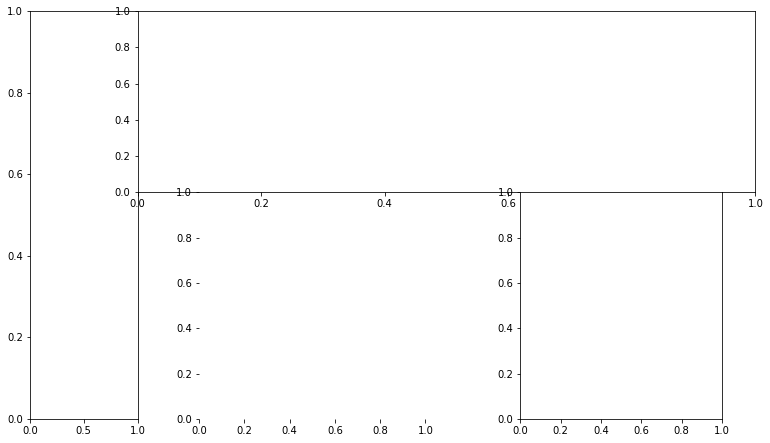

In [46]:
def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 

        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.

        Returns
        ----------
        colour map'''


    def hex_to_rgb(value):
        '''
        Converts hex to rgb colours
        value: string of 6 characters representing a hex colour.
        Returns: list length 3 of RGB values'''
        value = value.strip("#") # removes hash symbol if present
        lv = len(value)
        return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

    def rgb_to_dec(value):
        '''
        Converts rgb to decimal colours (i.e. divides each value by 256)
        value: list (length 3) of RGB values
        Returns: list (length 3) of decimal values'''
        return [v/256 for v in value]

    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))

    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = colors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

    
fig = plt.figure(figsize=(13, 7.5))
gs = fig.add_gridspec(2, 3, 
                      width_ratios=[0.4, 1.3, 1.0],
                      height_ratios=[0.8, 1], wspace=0.0, hspace=0.0)
ax_time = fig.add_subplot(gs[:, 0])
ax_text = fig.add_subplot(gs[0, 1:3])
ax_pie = fig.add_subplot(gs[1, 1])
ax_map = fig.add_subplot(gs[1, 2])

for year in range(1990, 2021):
# for year in range(2020, 2021):
    
    ################
    # Text summary #
    ################
    
    # Hide axis to create blank box
    ax_text.axis('off')
    
    # Add plot title and year
    ax_text.annotate('Coastal change in Australia'.upper(), 
                     xy=(0.03, 0.99), 
                     xycoords='axes fraction', 
                     va='top', 
                     fontsize=20, 
                     fontweight='bold')
    ax_text.annotate(year, 
                     xy=(0.97, 1.0), 
                     xycoords='axes fraction', 
                     ha='right', 
                     va='top', 
                     fontsize=65, 
                     fontweight='bold')
    
    # Calculate year-on-year change and set up symbols
    symbols = [u' \N{BLACK DOWN-POINTING TRIANGLE} down ', u' \N{BLACK UP-POINTING TRIANGLE} up ']
    absolute = pivot_df.loc[year]
    diffs = (pivot_df.loc[year] - pivot_df.loc[year - 1])
    triangles = pd.cut(diffs, [-100, 0, 100], labels=symbols)

    # Add retreat summary text
    retreat_text = (f"of Australia's non-rocky coastlines\nretreated by > 10 metres this year\n({triangles.iloc[0]}{diffs.abs().iloc[0]:.1f}% from {year - 1})")
    ax_text.annotate(f'{absolute.iloc[0]:.1f}%', (0.18, 0.76), xycoords='axes fraction', ha='right', va='top', fontsize=28, fontweight='bold')
    ax_text.annotate(retreat_text, (0.20, 0.77), xycoords='axes fraction', ha='left', va='top', fontsize=13)
    
    # Add grow summary text
    grow_text = (f"grew by > 10 metres this year\n({triangles.iloc[-1]}{diffs.abs().iloc[-1]:.1f}% from {year - 1})")
    ax_text.annotate(f'{absolute.iloc[-1]:.1f}%', (0.18, 0.41), xycoords='axes fraction', ha='right', va='top', fontsize=28, fontweight='bold')
    ax_text.annotate(grow_text, (0.20, 0.42), xycoords='axes fraction', ha='left', va='top', fontsize=13)
    
    # Add DEA logo overlay
    im_arr = imread('../data/raw/dea_logo.png')
    imagebox = OffsetImage(im_arr, zoom=0.18)
    ab = AnnotationBbox(imagebox, 
                        xy=(0.68, 0.58), 
                        xycoords='axes fraction', 
                        box_alignment=(0, 1), 
                        frameon=False) 
    ax_text.add_artist(ab) 
    
    
    ##############
    # Timeseries #
    ##############

    # Cumulative plot of each year-on-year change
    pivot_df.loc[1989:year].plot.area(cmap='RdBu', 
                                      linewidth=0.6,
                                      ax=ax_time, legend=False)  
    for i, li in enumerate(ax_time.lines):
        li.set_color('black')        
        if i < 3:
            li.set_ydata(li.get_ydata() - 0.45)
    ax_time.axhline(50, c='black', linestyle='dashed')
    ax_time.set_xlim([1989, year])
    ax_time.set_ylim([0, 100])
    ax_time.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax_time.ticklabel_format(useOffset=False, axis='x', style='plain')
    ax_time.xaxis.set_major_formatter(mtick.FormatStrFormatter('%g'))
    ax_time.set_xlabel(None)
    
    # Add retreat and growth annotations
    ax_time.annotate('Growth', (0.50, 0.965), xycoords='axes fraction', ha='center', va='center', color='white', fontsize=12, fontweight='bold')
    ax_time.annotate('Retreat', (0.50, 0.025), xycoords='axes fraction', ha='center', va='center', color='white', fontsize=12, fontweight='bold')
    
    
    ############
    # Pie plot #
    ############

    # Plot single year of data as a pie plot
    year_df = pivot_df.loc[year]
    year_df.plot.pie(cmap='RdBu', wedgeprops={"edgecolor":"black",'linewidth': 1.0, 'antialiased': True, "width": 0.5}, 
                     startangle=90, 
                     counterclock=True, 
                     fontsize=12,
                     autopct=lambda p:f'{p:.0f}%',
                     pctdistance=0.75, 
                     textprops={'fontsize': 14},
                     ax=ax_pie)
    
    # Add title and annotations
    ax_pie.annotate(year, (0.5, 0.5), xycoords='axes fraction', ha='center', va='center', fontsize=15)
    ax_pie.annotate(("Results based on year-on-year change in the median annual position of the\n"
                     "shoreline mapped by Digital Earth Australia Coastlines; Bishop-Taylor et al.\n(2021). "
                     "Available at https://doi.org/10.1016/j.rse.2021.112734 (CC BY 4.0)"), 
                    (-0.10, 0.055), xycoords='axes fraction', ha='left', va='top', fontsize=7.5, color='grey')
    ax_pie.set_title(" ".join(f"Shoreline change in {year}".upper()), fontsize=11, pad=10)
    ax_pie.set_anchor('N')
    ax_pie.set_ylabel(None);   
    ax_pie.texts[1].set_color('white')
    ax_pie.texts[-3].set_color('white')
    
    
    ############
    # Plot map #
    ############    

    # Select average rate of change for year and join to coastal regions data
    region_df = region_rate_df.xs(year, level='year').round(1)
    acsc_regions_results = acsc_regions.join(region_df)
    
    # Create a custom inset for legend
    cax = inset_axes(ax_map,
                 width=1.1,  
                 height=0.2,
                 bbox_to_anchor=[0.71, 0.12],
                 bbox_transform=plt.gcf().transFigure,
                 loc='center'
                   )
    
    # Plot coastal regions data     
    cmap = get_continuous_cmap(hex_list=['#67001f','#b2182b','#d6604d','#f4a582','#fddbc7',
                                         '#f7f7f7','#d1e5f0','#92c5de','#4393c3','#2166ac','#053061'], 
                               float_list=[0, 0.10, 0.30, 0.40, 0.45, 0.5, 0.55, 0.60, 0.70, 0.90, 1.0])

    acsc_regions_results.plot(column='distance', 
                              cmap=cmap,
                              vmin=-5, 
                              vmax=5, 
                              ax=ax_map, 
                              edgecolor='black', 
                              linewidth=1,
                              legend=True,
                              cax=cax,
                              legend_kwds={'label': None, 
                                           'orientation': "horizontal",
                                           'ticks': []})
    cax.set_title('Median shoreline change', pad=0, y=1.7)
    cax.get_yaxis().set_ticks([])
    for loc, lab in zip([-7.1, 0, 7.2], ['-5 m', '0 m', '+5 m']):
        cax.text(loc, -0.8, lab, ha='center', va='center', color='black')
    
    ax_map.annotate(f"{acsc_regions_results.loc['South-eastern Coasts'].distance:.1f} m", 
                    xy=(150.5, -36), 
                    xytext=(155, -42), 
                    arrowprops=dict(arrowstyle='-', lw=0.6),
                    fontsize=12,
                    va='center', ha='center')
    
    ax_map.annotate(f"{acsc_regions_results.loc['North-eastern Coasts'].distance:.1f} m", 
                xy=(145.49898, -17.10035), 
                xytext=(153, -14), 
                arrowprops=dict(arrowstyle='-', lw=0.6),
                fontsize=12,
                va='center', ha='center')
    
    ax_map.annotate(f"{acsc_regions_results.loc['Carpentaria Gulf Coasts'].distance:.1f} m        ", 
            xy=(139, -17), 
            xytext=(139, -8.5), 
            arrowprops=dict(arrowstyle='-', lw=0.6),
            fontsize=12,
            va='center', ha='center')
    
    ax_map.annotate(f"{acsc_regions_results.loc['North-western Coasts'].distance:.1f} m", 
            xy=(122.82193, -16.79609), 
            xytext=(119.5, -13), 
            arrowprops=dict(arrowstyle='-', lw=0.6),
            fontsize=12,
            va='center', ha='center')
    
    ax_map.annotate(f"{acsc_regions_results.loc['Western Coasts'].distance:.1f} m", 
            xy=(115.2, -30), 
            xytext=(111.8, -30), 
            arrowprops=dict(arrowstyle='-', lw=0.6),
            fontsize=12,
            va='center', ha='right')
    
    ax_map.annotate(f"{acsc_regions_results.loc['Southern Coasts'].distance:.1f} m", 
            xy=(128.5, -32), 
            xytext=(128.5, -37), 
            arrowprops=dict(arrowstyle='-', lw=0.6),
            fontsize=12,
            va='center', ha='center')
    
    # Add annotions and title
    ax_map.annotate('Australia', (0.48, 0.55), xycoords='axes fraction', ha='center', va='center', fontsize=15)
    ax_map.set_title(" ".join("Change by coastal region".upper()), fontsize=11, pad=10)
    ax_map.set_anchor('N')
    ax_map.axis('off');
    
    
    ################
    # Export image #
    ################
    
    fig.savefig(f'../visualisation/annual_snapshot/deacoastlines_annualupdate_{year}.png', 
                facecolor='white',
                transparent=False,
                bbox_inches='tight', 
                pad_inches=0.1, 
                dpi=111.5)
    
    ax_text.cla()
    ax_map.cla()
    ax_pie.cla()
    ax_time.cla()
    fig.delaxes(cax)


In [47]:
!ffmpeg -y -r 6 -start_number 1990 -i ../visualisation/annual_snapshot/deacoastlines_annualupdate_%4d.png -c:v libx264 -vf "fps=6,format=yuv420p,pad=ceil(iw/2)*2:ceil(ih/2)*2" ../visualisation/annual_snapshot/temp.mp4
!ffmpeg -y -i ../visualisation/annual_snapshot/temp.mp4 -filter_complex "[0]trim=0:5[hold],[0][hold]concat[extended],[extended][0]overlay" -pix_fmt yuv420p -c:a copy ../visualisation/annual_snapshot/temp2.mp4
!ffmpeg -y -i ../visualisation/annual_snapshot/temp2.mp4 -filter_complex "[0]trim=0:5[hold],[0][hold]concat[extended],[extended][0]overlay" -pix_fmt yuv420p -c:a copy ../visualisation/annual_snapshot/deacoastlines_annualupdate_{year}.mp4

ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-l

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** For assistance with any of the Python code or Jupyter Notebooks in this repository, please post a [Github issue](https://github.com/GeoscienceAustralia/DEACoastLines/issues/new). For questions or more information about this product, sign up to the [Open Data Cube Slack](https://join.slack.com/t/opendatacube/shared_invite/zt-d6hu7l35-CGDhSxiSmTwacKNuXWFUkg) and post on the [`#dea-coastlines`](https://app.slack.com/client/T0L4V0TFT/C018X6J9HLY/details/) channel.

**Last modified:** November 2021